In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Importing necessary libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Dropout, Bidirectional, LSTM, Dense, Reshape, Permute, Layer)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [6]:
# Reading and Unzipping Dataset
zip_speech = '/content/drive/MyDrive/audio_dataset/Audio_Speech_Actors_01-24.zip'
zip_song = '/content/drive/MyDrive/audio_dataset/Audio_Song_Actors_01-24.zip'
os.makedirs('/content/data', exist_ok=True)
!unzip -q "{zip_speech}" -d /content/data/speech
!unzip -q "{zip_song}" -d /content/data/song

replace /content/data/speech/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace /content/data/song/Actor_01/03-02-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
# File Listing and Label Extraction
data_paths = []
labels = []
for channel in ['speech', 'song']:
    base_path = f'/content/data/{channel}'
    for actor_folder in os.listdir(base_path):
        actor_path = os.path.join(base_path, actor_folder)
        if not os.path.isdir(actor_path): continue
        for file in os.listdir(actor_path):
            if file.lower().endswith('.wav'):
                parts = file.split('.')[0].split('-')
                emotion_id = int(parts[2])
                data_paths.append(os.path.join(actor_path, file))
                labels.append(emotion_id - 1)

data_paths = np.array(data_paths)
labels = np.array(labels)
print("Total samples:", len(data_paths))

Total samples: 2452


In [8]:
# Feature Extraction
def extract_log_mel(path, sr=22050, duration=3, n_mels=128):
    y, _ = librosa.load(path, sr=sr, duration=duration)
    if len(y) < sr*duration:
        y = np.pad(y, (0, sr*duration - len(y)), mode='constant')
    else:
        y = y[:sr*duration]
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    if S_db.shape[1] < 128:
        pad_width = 128 - S_db.shape[1]
        S_db = np.pad(S_db, ((0,0),(0,pad_width)), mode='constant')
    else:
        S_db = S_db[:, :128]
    return S_db

print("Extracting log-Mel features...")
mel_features = np.zeros((len(data_paths), 128, 128), dtype=np.float32)
for i, path in enumerate(data_paths):
    mel = extract_log_mel(path)
    mel_features[i] = mel
print("Features extracted.")

Extracting log-Mel features...
Features extracted.


In [13]:
# Train/Test Split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    mel_features, labels, test_size=0.2, random_state=42, stratify=labels)

# Normalize Features Using Train Only
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0) + 1e-8
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [14]:
# Pseudo Augmentation
aug_X_train, aug_y_train = [], []
for i in range(len(X_train)):
    mel = X_train[i,...,0]
    if np.random.rand() < 0.5:
        mel_aug = mel + np.random.randn(*mel.shape) * 0.01
    else:
        mel_aug = mel.copy()
        t = mel_aug.shape[1]
        mask_len = t // 10
        start = np.random.randint(0, t-mask_len)
        mel_aug[:, start:start+mask_len] = 0
    aug_X_train.append(mel_aug[..., np.newaxis])
    aug_y_train.append(y_train_raw[i])

X_train = np.concatenate([X_train, np.array(aug_X_train)], axis=0)
y_train_raw = np.concatenate([y_train_raw, np.array(aug_y_train)], axis=0)

#Label Encoding
num_classes = 8
lb = LabelEncoder()
y_train_enc = tf.keras.utils.to_categorical(lb.fit_transform(y_train_raw), num_classes)
y_test_enc = tf.keras.utils.to_categorical(lb.transform(y_test_raw), num_classes)

# Class Weights
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_raw), y=y_train_raw)
cw[7] *= 1.5
class_weights = {i: cw[i] for i in range(num_classes)}

In [15]:
# Custom Attention
class Attention(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros", trainable=True)
        super().build(input_shape)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

In [12]:
# Model Building
input_shape = (128, 128, 1)
inputs = Input(shape=input_shape)

# Conv Block 1
x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Conv Block 2
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Conv Block 3
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Reshape for BiLSTM
x = Permute((2,1,3))(x)
x = Reshape((16, 16*128))(x)

# BiLSTM + Attention
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Attention()(x)
x = Dropout(0.4)(x)

# Output
outputs = Dense(num_classes, activation='softmax')(x)

# Compile model
model = Model(inputs, outputs)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16, 64)         │       532,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 64)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,904 (2.39 MB)

 Trainable params: 626,456 (2.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# Model Training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]
history = model.fit(
    X_train, y_train_enc,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.2939 - loss: 1.9553 - val_accuracy: 0.1043 - val_loss: 2.1900 - learning_rate: 0.0010
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5142 - loss: 1.4978 - val_accuracy: 0.1399 - val_loss: 2.2508 - learning_rate: 0.0010
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6507 - loss: 1.2380 - val_accuracy: 0.3919 - val_loss: 1.7736 - learning_rate: 0.0010
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7267 - loss: 1.1087 - val_accuracy: 0.6031 - val_loss: 1.3132 - learning_rate: 0.0010
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7872 - loss: 0.9844 - val_accuracy: 0.8041 - val_loss: 0.9336 - learning_rate: 0.0010
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8405 - loss: 0.8861 - val_accuracy: 0.8015 - val_loss: 0.8958 - learning_rate: 0.0010
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8763 - loss: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

Classification Report:
              precision    recall  f1-score   support

     neutral       0.85      0.92      0.89        38
        calm       0.88      0.93      0.90        75
       happy       0.85      0.73      0.79        75
         sad       0.77      0.71      0.74        75
       angry       0.88      0.93      0.90        75
        fear       0.80      0.75      0.77        75
     disgust       0.81      0.87      0.84        39
    surprise       0.75      0.85      0.80        39

    accuracy                           0.83       491
   macro avg       0.82      0.84      0.83       491
weighted avg       0.83      0.83      0.82       491



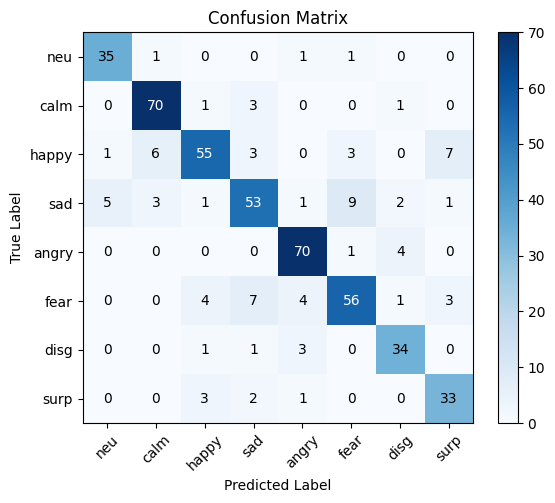

In [17]:
# Model Evaluation
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test_raw
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[
    'neutral','calm','happy','sad','angry','fear','disgust','surprise']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, ['neu','calm','happy','sad','angry','fear','disg','surp'], rotation=45)
plt.yticks(tick_marks, ['neu','calm','happy','sad','angry','fear','disg','surp'])
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()